In [1]:
import pandas as pd
import sys

sys.path.append('../_styling/')
from style import prep_plot, GRAY1, GRAY2, GRAY3, BLACK

In [2]:
df = pd.read_csv("ai_ngram_data.csv")
df.head(1)

,Year,Value
0,2019,0.000313


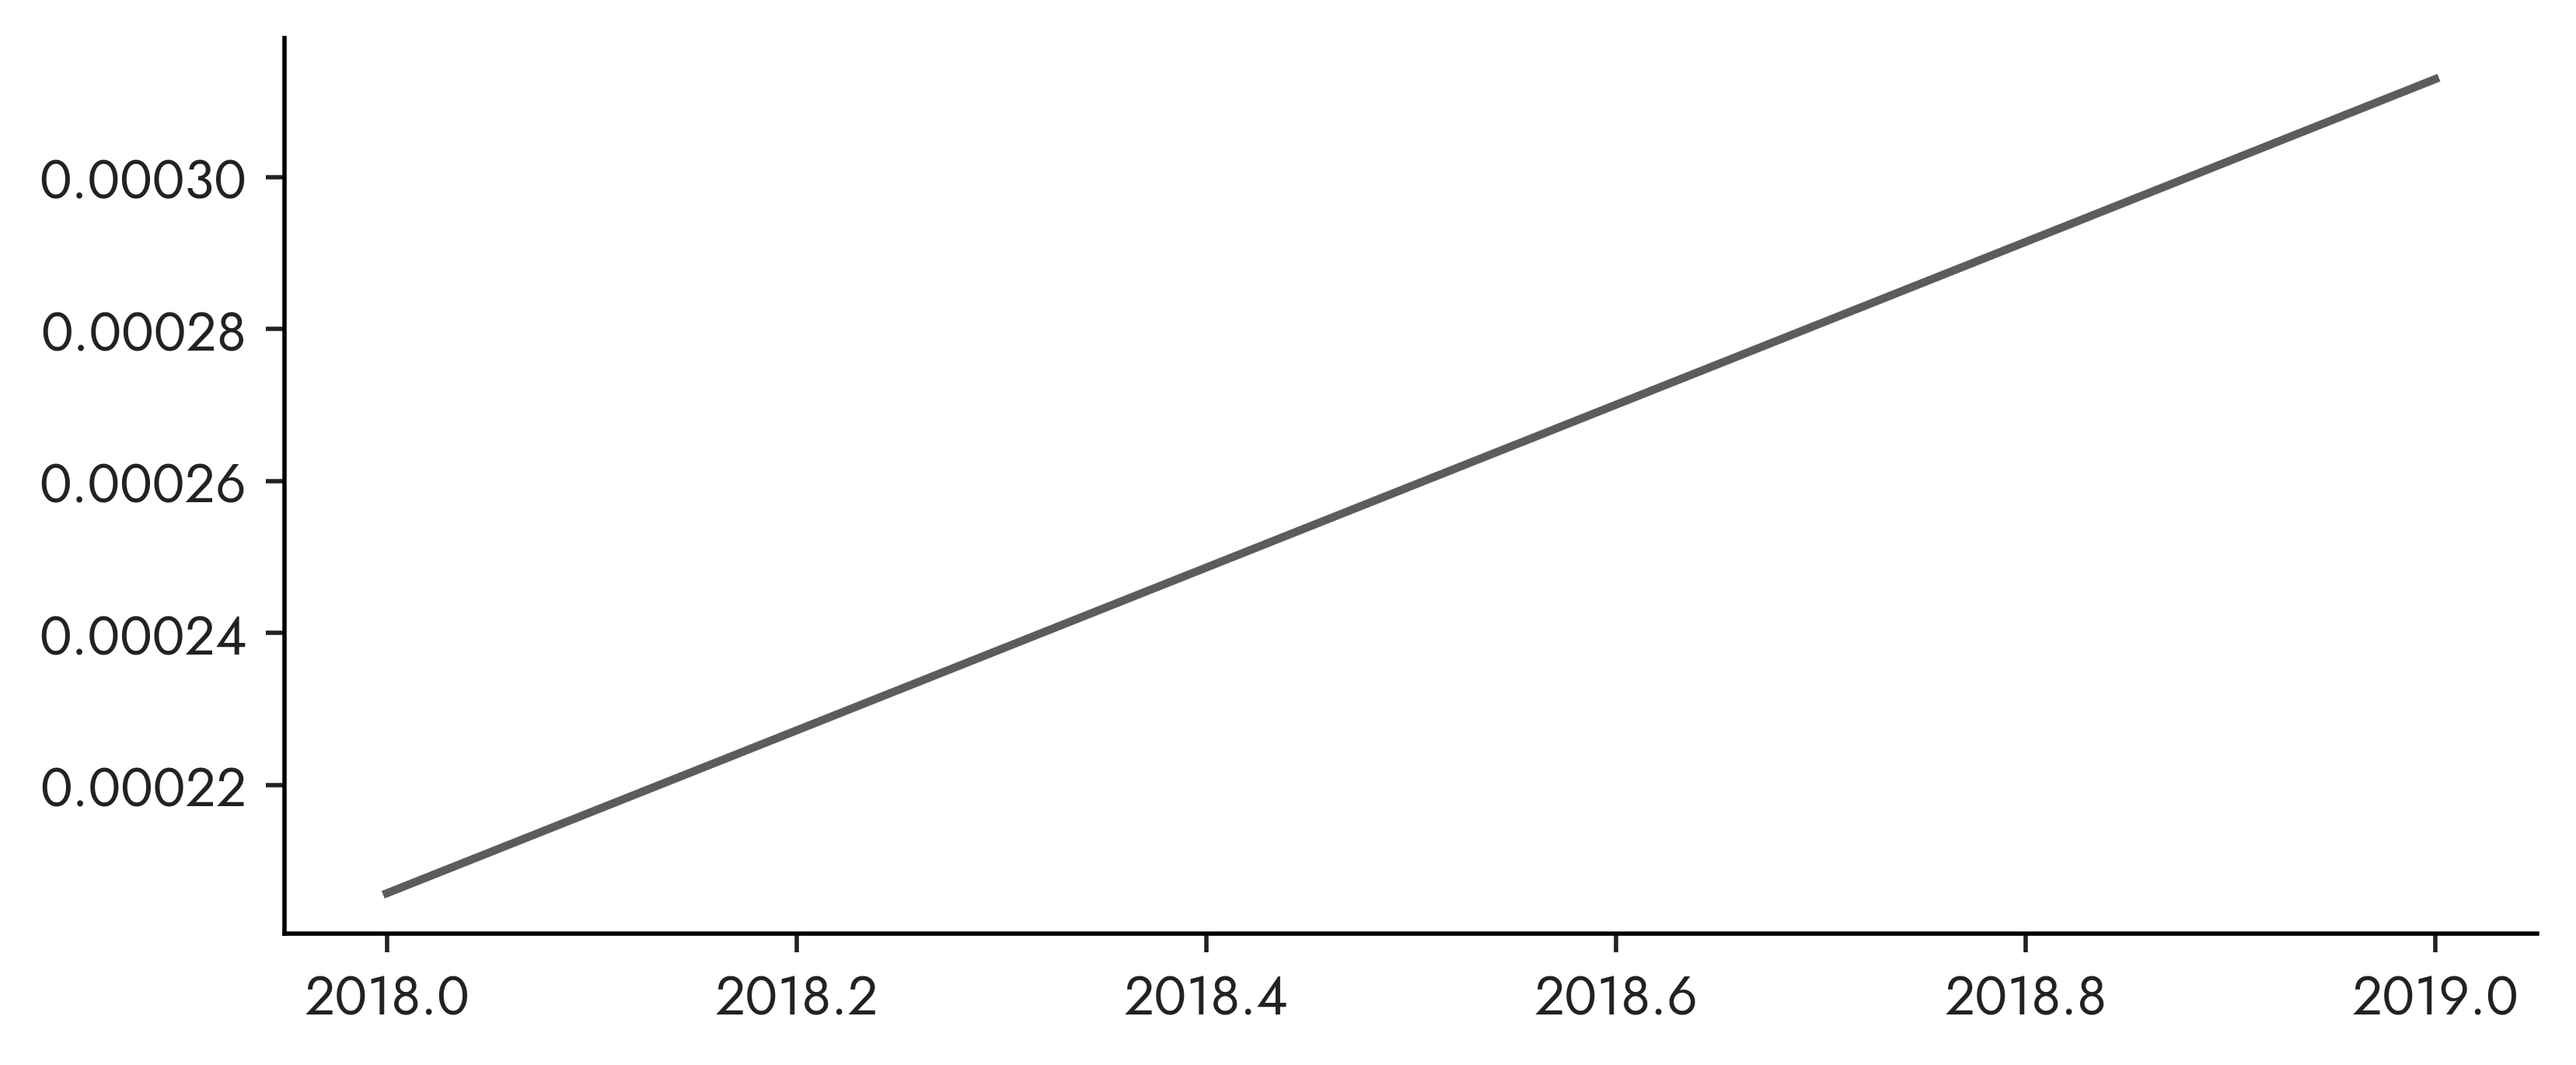

In [4]:
plt = prep_plot()
plt.plot(df['Year'], df['Value'], color=GRAY1)
plt.savefig("ai_ngrams.png")